The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.13.2 -f https://d2l.ai/whl.html # installing d2l


# Network in Network (NiN)
:label:`sec_nin`

LeNet, AlexNet, and VGG all share a common design pattern:
extract features exploiting *spatial* structure
via a sequence of convolutions and pooling layers
and then post-process the representations via fully-connected layers.
The improvements upon LeNet by AlexNet and VGG mainly lie
in how these later networks widen and deepen these two modules.
Alternatively, one could imagine using fully-connected layers
earlier in the process.
However, a careless use of dense layers might give up the
spatial structure of the representation entirely,
Network in Network (NiN) blocks offer an alternative.
They were proposed in :cite:`Lin.Chen.Yan.2013` based on a very simple insight---to
use an MLP on the channels for each pixel separately.

## NiN Blocks

Recall that the inputs and outputs of convolutional layers
consist of four-dimensional arrays with axes
corresponding to the batch, channel, height, and width.
Also recall that the inputs and outputs of fully-connected layers
are typically two-dimensional arrays corresponding to the batch, and features.
The idea behind NiN is to apply a fully-connected layer
at each pixel location (for each height and  width).
If we tie the weights across each spatial location,
we could think of this as a $1\times 1$ convolutional layer
(as described in :numref:`sec_channels`)
or as a fully-connected layer acting independently on each pixel location.
Another way to view this is to think of each element in the spatial dimension
(height and width) as equivalent to an example
and the channel as equivalent to a feature.
:numref:`fig_nin` illustrates the main structural differences
between NiN and AlexNet, VGG, and other networks.

![The figure on the left shows the network structure of AlexNet and VGG, and the figure on the right shows the network structure of NiN. ](http://d2l.ai/_images/nin.svg)
:width:`600px`
:label:`fig_nin`


The NiN block consists of one convolutional layer
followed by two $1\times 1$ convolutional layers that act as
per-pixel fully-connected layers with ReLU activations.
The convolution width of the first layer is typically set by the user.
The subsequent widths are fixed to $1 \times 1$.


In [1]:
from d2l import torch as d2l
import torch
from torch import nn

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

## NiN Model

The original NiN network was proposed shortly after AlexNet
and clearly draws some inspiration.
NiN uses convolutional layers with window shapes
of $11\times 11$, $5\times 5$, and $3\times 3$,
and the corresponding numbers of output channels are the same as in AlexNet. Each NiN block is followed by a maximum pooling layer
with a stride of 2 and a window shape of $3\times 3$.

One significant difference between NiN and AlexNet
is that NiN avoids dense connections altogether.
Instead, NiN uses an NiN block with a number of output channels equal to the number of label classes, followed by a *global* average pooling layer,
yielding a vector of [logits](https://en.wikipedia.org/wiki/Logit).
One advantage of NiN's design is that it significantly
reduces the number of required model parameters.
However, in practice, this design sometimes requires
increased model training time.


In [2]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveMaxPool2d((1,1)),
    nn.Flatten())

We create a data example to see the output shape of each block.


In [3]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


## Data Acquisition and Training

As before we use Fashion-MNIST to train the model.
NiN's training is similar to that for AlexNet and VGG,
but it often uses a larger learning rate.


loss 0.367, train acc 0.861, test acc 0.860
3156.9 examples/sec on cuda:0


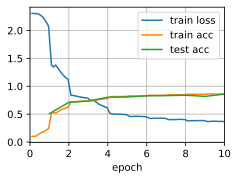

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## Summary

* NiN uses blocks consisting of a convolutional layer and multiple $1\times 1$ convolutional layer. This can be used within the convolutional stack to allow for more per-pixel nonlinearity.
* NiN removes the fully connected layers and replaces them with global average pooling (i.e., summing over all locations) after reducing the number of channels to the desired number of outputs (e.g., 10 for Fashion-MNIST).
* Removing the dense layers reduces overfitting. NiN has dramatically fewer parameters.
* The NiN design influenced many subsequent convolutional neural networks designs.

## Exercises

1. Tune the hyper-parameters to improve the classification accuracy.
1. Why are there two $1\times 1$ convolutional layers in the NiN block? Remove one of them, and then observe and analyze the experimental phenomena.
1. Calculate the resource usage for NiN
    * What is the number of parameters?
    * What is the amount of computation?
    * What is the amount of memory needed during training?
    * What is the amount of memory needed during inference?
1. What are possible problems with reducing the $384 \times 5 \times 5$ representation to a $10 \times 5 \times 5$ representation in one step?


[Discussions](https://discuss.d2l.ai/t/80)
